***This notebook is built off of Germano's existing LSCP notebook:

***Objective:  Attempt to solve the Location Coverage Backup Problem as a script and access PuLP manually (outside of PySAL spopt ecosystem)

***Steps:
1)  Solve for LSCP

2)  Retrieve the minimum number of facilities required from LSCP result

3)  Assign this result to variable p and use for defining LpConstraint

In [1]:
from spopt.locate.coverage import LSCP
from spopt.locate.util import simulated_geo_points

import numpy
import geopandas
import pulp
import spaghetti
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [2]:
CLIENT_COUNT = 100 # quantity demand points
FACILITY_COUNT = 10 # quantity supply points

MAX_COVERAGE = 8 # maximum service radius in meters

# Random seeds for reproducibility
CLIENT_SEED = 5
FACILITY_SEED = 6

solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)

In [3]:
lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

In [4]:
street = spaghetti.element_as_gdf(ntw, arcs=True)

street_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(street["geometry"].buffer(0.2).unary_union),
    crs=street.crs,
    columns=["geometry"],
)

<AxesSubplot:>

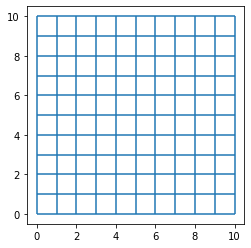

In [5]:
street.plot()

In [6]:
client_points = simulated_geo_points(street_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED)
facility_points = simulated_geo_points(
    street_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

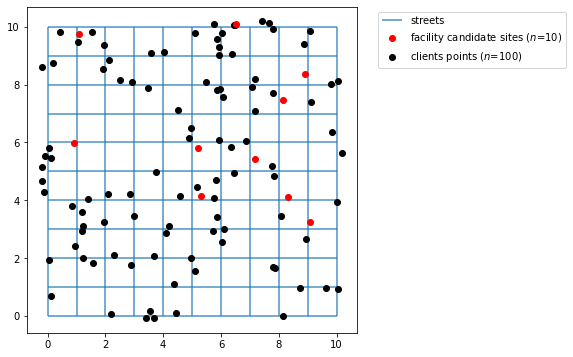

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facility_points.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=10)')
client_points.plot(ax=ax, color='black', label='clients points ($n$=100)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

In [8]:
ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)

ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

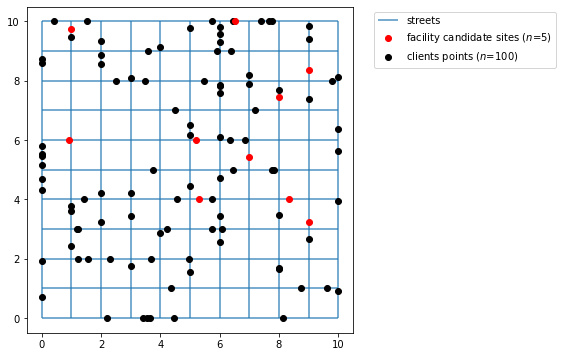

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facilities_snapped.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=5)')
clients_snapped.plot(ax=ax, color='black', label='clients points ($n$=100)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

In [10]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)

In [11]:
cost_matrix

array([[12.60302601,  3.93598651,  8.16571655,  6.04319467,  5.65607701,
        11.18214123,  7.77728592,  7.39698689,  8.4298727 ,  1.90391589],
       [13.10096347,  4.43392397,  8.66365401,  6.54113213,  5.15813955,
        11.68007869,  7.98645534,  7.89492435,  8.92781016,  1.88691468],
       [ 6.9095462 ,  4.2425067 ,  2.47223674,  0.34971486,  5.34955682,
         5.48866142,  6.20496192,  4.29649292,  2.73639289,  7.5973957 ],
       [ 2.98196832,  7.84581224,  3.45534114,  3.57786302,  6.25374871,
         1.56108354,  4.60165639,  2.69318739,  1.19118499, 11.52497358],
       [ 7.5002892 ,  6.32806975,  4.55779979,  6.43527791, 11.75939222,
         7.57422447, 12.61479732, 10.70632832,  7.67344251, 10.00723109],
       [ 0.60209077, 11.42987132,  5.03940023,  7.16192211,  9.8378078 ,
         2.02297555,  5.71659889,  5.80812989,  4.77524408, 15.10903267],
       [ 5.37335867,  6.20113923,  2.43086927,  4.30834738,  9.6324617 ,
         5.44729395, 10.4878668 ,  8.5793978 

In [12]:
# create an array, mark values with a 1 if <= 8
# all other values marked w/ zero (no coverage)
aij = numpy.zeros(cost_matrix.shape)
aij[cost_matrix <= MAX_COVERAGE] = 1
#! aij is the coverage matrix
aij

array([[0., 1., 0., 1., 1., 0., 1., 1., 0., 1.],
       [0., 1., 0., 1., 1., 0., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0., 1., 0., 0., 1., 0.],
       [1., 0., 1., 1., 0., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0., 1., 0., 0., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 0., 1., 1., 1., 1., 0., 1., 1., 0.],
       [0., 1., 0., 1., 1., 0., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 0., 0., 0., 0., 1., 1.],
       [0., 1., 1., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 0., 0., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 0., 1., 1., 0., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 0., 

All code before this is really just setup... Now with the information we have how can we use the PuLP solver to solve for maximizing backup coverage.

First: Solve for LSCP <br>
Second: Use p (min # of facilities required) as the minimum required facilites in the LpProblem constraint.

In [13]:
lscp_from_cost_matrix = LSCP.from_cost_matrix(cost_matrix, MAX_COVERAGE)
print(lscp_from_cost_matrix.problem)
lscp_from_cost_matrix.solve(solver)

LSCP:
MINIMIZE
1*x_0_ + 1*x_1_ + 1*x_2_ + 1*x_3_ + 1*x_4_ + 1*x_5_ + 1*x_6_ + 1*x_7_ + 1*x_8_ + 1*x_9_ + 0
SUBJECT TO
_C1: x_1_ + x_3_ + x_4_ + x_6_ + x_7_ + x_9_ >= 1

_C2: x_1_ + x_3_ + x_4_ + x_6_ + x_7_ + x_9_ >= 1

_C3: x_0_ + x_1_ + x_2_ + x_3_ + x_4_ + x_5_ + x_6_ + x_7_ + x_8_ + x_9_ >= 1

_C4: x_0_ + x_1_ + x_2_ + x_3_ + x_4_ + x_5_ + x_6_ + x_7_ + x_8_ >= 1

_C5: x_0_ + x_1_ + x_2_ + x_3_ + x_5_ + x_8_ >= 1

_C6: x_0_ + x_2_ + x_3_ + x_5_ + x_6_ + x_7_ + x_8_ >= 1

_C7: x_0_ + x_1_ + x_2_ + x_3_ + x_5_ + x_8_ >= 1

_C8: x_0_ + x_1_ + x_2_ + x_3_ + x_4_ + x_5_ + x_6_ + x_7_ + x_8_ >= 1

_C9: x_0_ + x_2_ + x_3_ + x_4_ + x_5_ + x_7_ + x_8_ >= 1

_C10: x_1_ + x_3_ + x_4_ + x_9_ >= 1

_C11: x_1_ + x_2_ >= 1

_C12: x_0_ + x_1_ + x_2_ + x_3_ + x_4_ + x_5_ + x_6_ + x_7_ + x_8_ + x_9_ >= 1

_C13: x_1_ + x_2_ + x_3_ + x_8_ + x_9_ >= 1

_C14: x_1_ + x_2_ + x_3_ + x_8_ + x_9_ >= 1

_C15: x_2_ + x_3_ + x_4_ + x_5_ + x_6_ + x_7_ + x_8_ + x_9_ >= 1

_C16: x_1_ + x_2_ + x_3_ + x_4_ + x_6_ + 

In [14]:
#LSCP object attributes and methods
dir(lscp_from_cost_matrix)

#LP Problem facility variables
lscp_from_cost_matrix.fac_vars

[x_0_, x_1_, x_2_, x_3_, x_4_, x_5_, x_6_, x_7_, x_8_, x_9_]

In [15]:
#get the minimum number of facilities needed from result
p = lscp_from_cost_matrix.problem.objective.value()
print(p)

3.0


In [16]:
if lscp_from_cost_matrix.problem.status == -1:
    print("LSCP problem is infeasible, cannot solve for backup coverage!")

In [17]:
from spopt.locate.base import (
    BaseOutputMixin,
    CoveragePercentageMixin,
    LocateSolver,
    FacilityModelBuilder,
)
import numpy as np

Started creating a LSCPB object. Still very much in development...

In [18]:
#use the LSCP object as a framework for a LSCPB object
class LSCPB(LocateSolver, BaseOutputMixin): #LSCPB shouldn't necessarily inherit from LSCP BUT should be able to call LSCP object?
    """
    LSCPB class implements Location Set Covering Problem - Backup optimization model and solves it.

    Parameters
    ----------
    name: str
        Problem name
    problem: pulp.LpProblem
        Pulp instance of optimization model that contains constraints, variables and objective function.

    Attributes
    ----------
    name: str
        Problem name
    problem: pulp.LpProblem
        Pulp instance of optimization model that contains constraints, variables and objective function.
    fac2cli : np.array
        2-d array MxN, where m is number of facilities and n is number of clients. Each row represents a facility and has an array containing clients index meaning that the facility-i cover the entire array.
    cli2fac: np.array
        2-d MxN, where m is number of clients and n is number of facilities. Each row represent a client and has an array containing facility index meaning that the client is covered by the facility ith.
    aij: np.array
        Cost matrix 2-d array 
    """

    def __init__(self, name: str, problem: pulp.LpProblem):
        super().__init__(name, problem)

    def __add_obj(self) -> None:
        """
        Add objective function to model:
        (Coverage Variable)
        Maximize U1 + U2 + U3 + U4 + U5 + ... + Uj

        Returns
        -------
        None
        """
        cov_vars = getattr(self, "cli_vars")
        self.problem += pulp.lpSum(cov_vars), "objective function"

    @classmethod
    def from_cost_matrix(
        cls,
        cost_matrix: np.array,
        service_radius: float,
        predefined_facilities_arr: np.array = None,
        name: str = "LSCP-B",
    ):
        """
        Create a LSCPB object based on a cost matrix.

        Parameters
        ----------
        cost_matrix: np.array
            two-dimensional distance array between facility points and demand point
        service_radius: float
            maximum acceptable service distance by problem
        name: str, default="LSCP"
            name of the problem

        Returns
        -------
        LSCPB object

        Examples
        --------
        >>> from spopt.locate.coverage import LSCP
        >>> from spopt.locate.util import simulated_geo_points
        >>> import pulp
        >>> import spaghetti

        Create regular lattice

        >>> lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
        >>> ntw = spaghetti.Network(in_data=lattice)
        >>> street = spaghetti.element_as_gdf(ntw, arcs=True)
        >>> street_buffered = geopandas.GeoDataFrame(
        ...                            geopandas.GeoSeries(street["geometry"].buffer(0.2).unary_union),
        ...                            crs=street.crs,
        ...                            columns=["geometry"])

        Simulate points belong to lattice

        >>> demand_points = simulated_geo_points(street_buffered, needed=100, seed=5)
        >>> facility_points = simulated_geo_points(street_buffered, needed=5, seed=6)

        Snap points to the network

        >>> ntw.snapobservations(demand_points, "clients", attribute=True)
        >>> clients_snapped = spaghetti.element_as_gdf(ntw, pp_name="clients", snapped=True)
        >>> ntw.snapobservations(facility_points, "facilities", attribute=True)
        >>> facilities_snapped = spaghetti.element_as_gdf(ntw, pp_name="facilities", snapped=True)

        Calculate the cost matrix
        >>> cost_matrix = ntw.allneighbordistances(
        ...    sourcepattern=ntw.pointpatterns["clients"],
        ...    destpattern=ntw.pointpatterns["facilities"])

        Create LSCP instance from cost matrix

        >>> lscp_from_cost_matrix = LSCP.from_cost_matrix(cost_matrix, max_coverage=8)
        >>> lscp_from_cost_matrix = lscp_from_cost_matrix.solve(pulp.PULP_CBC_CMD(msg=False))

        Get facility lookup demand coverage array

        >>> lscp_from_cost_matrix.facility_client_array()
        >>> lscp_from_cost_matrix.fac2cli

        """

        r_fac = range(cost_matrix.shape[1])
        r_cli = range(cost_matrix.shape[0])

        model = pulp.LpProblem(name, pulp.LpMaximize)
        lscpb = LSCPB(name, model)

        FacilityModelBuilder.add_facility_integer_variable(lscpb, r_fac, "x[{i}]")
        #!EO added to build objective
        FacilityModelBuilder.add_client_integer_variable(lscpb, r_cli, "u[{i}]")

        lscpb.aij = np.zeros(cost_matrix.shape)
        lscpb.aij[cost_matrix <= service_radius] = 1

        #!!!what does this if block do??
        if predefined_facilities_arr is not None:
            FacilityModelBuilder.add_predefined_facility_constraint(
                lscpb, lscpb.problem, predefined_facilities_arr
            )

        lscpb.__add_obj()
        FacilityModelBuilder.add_set_covering_constraint(
            lscpb, lscpb.problem, lscpb.aij, r_fac, r_cli
        )

        return lscpb


    def facility_client_array(self) -> None:
        """
        Create an array 2d MxN, where m is number of facilities and n is number of clients. Each row represent a facility and has an array containing clients index meaning that the facility-i cover the entire array.

        Returns
        -------
        None
        """

        fac_vars = getattr(self, "fac_vars")
        len_fac_vars = len(fac_vars)

        self.fac2cli = []

        for j in range(len_fac_vars):
            array_cli = []
            if fac_vars[j].value() > 0:
                for i in range(self.aij.shape[0]):
                    if self.aij[i][j] > 0:
                        array_cli.append(i)

            self.fac2cli.append(array_cli)

    def solve(self, solver: pulp.LpSolver, results: bool = True):
        """
        Solve the LSCP model

        Parameters
        ----------
        solver: pulp.LpSolver
            solver supported by pulp package

        results: bool
            if True it will create metainfo - which facilities cover which demand and vice-versa, and the uncovered demand - about the model results

        Returns
        -------
        LSCP object
        """
        self.problem.solve(solver)
        self.check_status()

        if results:
            self.facility_client_array()
            self.client_facility_array()

        return self

I could use some assistance in setting this up locally. If I want to modify the spopt base file to include some additional methods for LSCPB object creation, how would I do that? I'd need to be running my tests off a local version of the spopt package....

In [20]:
lscpb_from_cost_matrix = LSCPB.from_cost_matrix(cost_matrix, MAX_COVERAGE)
#!could use add_facility_constraint instead? Would go in LSCPB class definition
lscpb_from_cost_matrix.problem += pulp.LpConstraint(sum(lscpb_from_cost_matrix.fac_vars), sense=pulp.LpConstraintEQ, rhs=p, name='Facility Constraint')

lscpb_from_cost_matrix.problem

#! Subject to: isn't quite right, need to subtract coverage from left side of equation
#! one way to acheive this would be to add another @static method to the FacilityModelBuilder class in base.py
#! we currently have add_set_covering_constraint but I don't think it's sufficient 
#! for LSCP-B and from a breif glance it doesn't look like it would be very clean to try
#! and retrofit for the new model. 
#! adding a add_backup_covering_constraint method would be quite useful

#!need to double check and see if my variables are correct.....


LSCP-B:
MAXIMIZE
1*u_0_ + 1*u_10_ + 1*u_11_ + 1*u_12_ + 1*u_13_ + 1*u_14_ + 1*u_15_ + 1*u_16_ + 1*u_17_ + 1*u_18_ + 1*u_19_ + 1*u_1_ + 1*u_20_ + 1*u_21_ + 1*u_22_ + 1*u_23_ + 1*u_24_ + 1*u_25_ + 1*u_26_ + 1*u_27_ + 1*u_28_ + 1*u_29_ + 1*u_2_ + 1*u_30_ + 1*u_31_ + 1*u_32_ + 1*u_33_ + 1*u_34_ + 1*u_35_ + 1*u_36_ + 1*u_37_ + 1*u_38_ + 1*u_39_ + 1*u_3_ + 1*u_40_ + 1*u_41_ + 1*u_42_ + 1*u_43_ + 1*u_44_ + 1*u_45_ + 1*u_46_ + 1*u_47_ + 1*u_48_ + 1*u_49_ + 1*u_4_ + 1*u_50_ + 1*u_51_ + 1*u_52_ + 1*u_53_ + 1*u_54_ + 1*u_55_ + 1*u_56_ + 1*u_57_ + 1*u_58_ + 1*u_59_ + 1*u_5_ + 1*u_60_ + 1*u_61_ + 1*u_62_ + 1*u_63_ + 1*u_64_ + 1*u_65_ + 1*u_66_ + 1*u_67_ + 1*u_68_ + 1*u_69_ + 1*u_6_ + 1*u_70_ + 1*u_71_ + 1*u_72_ + 1*u_73_ + 1*u_74_ + 1*u_75_ + 1*u_76_ + 1*u_77_ + 1*u_78_ + 1*u_79_ + 1*u_7_ + 1*u_80_ + 1*u_81_ + 1*u_82_ + 1*u_83_ + 1*u_84_ + 1*u_85_ + 1*u_86_ + 1*u_87_ + 1*u_88_ + 1*u_89_ + 1*u_8_ + 1*u_90_ + 1*u_91_ + 1*u_92_ + 1*u_93_ + 1*u_94_ + 1*u_95_ + 1*u_96_ + 1*u_97_ + 1*u_98_ + 1*u_99_ + 1*

In [23]:
# create a LP problem with the method LpProblem in PuLP
#del(prob)
prob = pulp.LpProblem("LSCP-B", pulp.LpMaximize)

In [24]:
#how many clients
range_client = range(cost_matrix.shape[0])

#how many facilities
range_facility = range(cost_matrix.shape[1]) 

In [27]:
# create variables for the facilities, demand nodes, and coverage
fac_vars = [
    pulp.LpVariable(
        "facility_{}".format(i), lowBound=0, upBound=1, cat=pulp.LpInteger
    )
    for i in range_facility
]
print(fac_vars)

#may not need to be a variable....
dem_vars = [
    pulp.LpVariable(
        "demandNode_{}".format(i), lowBound=0, upBound=1, cat=pulp.LpInteger
    )
    for i in range_client
]
print(dem_vars)

# coverage variable - this variable should be 1 anytime a demand node is covered > 1x
# i feel like this varibale should be created differently so that it is either assigned 0,1
# based on the coverage status of a demand node
cov_var = [
    pulp.LpVariable(
        "coverage_{}".format(i), lowBound=0, upBound=1, cat=pulp.LpInteger
    )
    for i in range_client
]
    
print(cov_var)

[facility_0, facility_1, facility_2, facility_3, facility_4, facility_5, facility_6, facility_7, facility_8, facility_9]
[demandNode_0, demandNode_1, demandNode_2, demandNode_3, demandNode_4, demandNode_5, demandNode_6, demandNode_7, demandNode_8, demandNode_9, demandNode_10, demandNode_11, demandNode_12, demandNode_13, demandNode_14, demandNode_15, demandNode_16, demandNode_17, demandNode_18, demandNode_19, demandNode_20, demandNode_21, demandNode_22, demandNode_23, demandNode_24, demandNode_25, demandNode_26, demandNode_27, demandNode_28, demandNode_29, demandNode_30, demandNode_31, demandNode_32, demandNode_33, demandNode_34, demandNode_35, demandNode_36, demandNode_37, demandNode_38, demandNode_39, demandNode_40, demandNode_41, demandNode_42, demandNode_43, demandNode_44, demandNode_45, demandNode_46, demandNode_47, demandNode_48, demandNode_49, demandNode_50, demandNode_51, demandNode_52, demandNode_53, demandNode_54, demandNode_55, demandNode_56, demandNode_57, demandNode_58, dem

In [28]:
#minimum reqired coverage
coverage_min = 2

# this is still quite useful - it describes the relationship between facilities & demand nodes
'''for i in range_client:
    prob += (
        # I should understand the below line better // maybe have them reiterate for me?
        #!lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + cov_var[i]
        lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + cov_var[i]
    )'''

for i in range_client:
    if sum(aij[i]) >= coverage_min: # demand unit has meets coverage requirement
        prob += (
            pulp.lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + 1*cov_var[i]
        )
    else: #demand unit does not meet coverage requirement
        prob += (
            pulp.lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + 0*cov_var[i]
        )

prob += pulp.lpSum(1*i for i in cov_var), "objective function"

#constraints:
#  - the number of facilities chosen should be <= p
#  - all facilities should be either 0 or 1
#  - Ui should be <= 1 

# rhs – numerical value of constraint target, which should be >= p from LSCP result
prob += pulp.LpConstraint(sum(fac_vars), sense=pulp.LpConstraintEQ, rhs=p, name='Facility Constraint')

print(prob)

LSCP-B:
MAXIMIZE
1*coverage_0 + 1*coverage_1 + 1*coverage_10 + 1*coverage_11 + 1*coverage_12 + 1*coverage_13 + 1*coverage_14 + 1*coverage_15 + 1*coverage_16 + 1*coverage_17 + 1*coverage_18 + 1*coverage_19 + 1*coverage_2 + 1*coverage_20 + 1*coverage_21 + 1*coverage_22 + 1*coverage_23 + 1*coverage_24 + 1*coverage_25 + 1*coverage_26 + 1*coverage_27 + 1*coverage_28 + 1*coverage_29 + 1*coverage_3 + 1*coverage_30 + 1*coverage_31 + 1*coverage_32 + 1*coverage_33 + 1*coverage_34 + 1*coverage_35 + 1*coverage_36 + 1*coverage_37 + 1*coverage_38 + 1*coverage_39 + 1*coverage_4 + 1*coverage_40 + 1*coverage_41 + 1*coverage_42 + 1*coverage_43 + 1*coverage_44 + 1*coverage_45 + 1*coverage_46 + 1*coverage_47 + 1*coverage_48 + 1*coverage_49 + 1*coverage_5 + 1*coverage_50 + 1*coverage_51 + 1*coverage_52 + 1*coverage_53 + 1*coverage_54 + 1*coverage_55 + 1*coverage_56 + 1*coverage_57 + 1*coverage_58 + 1*coverage_59 + 1*coverage_6 + 1*coverage_60 + 1*coverage_61 + 1*coverage_62 + 1*coverage_63 + 1*coverage_64 

In [30]:
prob.solve()
'''print('Coverage Values')   
for i in cov_var:
    print(i,i.varValue)'''

print('\n'+'Total Clients Covered >= 2 Times:', pulp.value(prob.objective))

print('\n'+ 'Chosen Facility Values')
for i in fac_vars:
    if i.varValue == 1:
        print(i,i.varValue)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/pysaldev/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/fq/47y89n756hg5n9zwbqd79nhw0000gn/T/7378b389fc3a49e0ab5bcbae08b0f6d5-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/fq/47y89n756hg5n9zwbqd79nhw0000gn/T/7378b389fc3a49e0ab5bcbae08b0f6d5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 106 COLUMNS
At line 1199 RHS
At line 1301 BOUNDS
At line 1412 ENDATA
Problem MODEL has 101 rows, 110 columns and 772 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 90 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 53 strengthened rows, 0 substitutions
Cgl0004I processed model has 100 rows, 108 columns (108 integer (108 of which binary)) and 761 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial 

In [31]:
prob.status

1